In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
import multiprocessing
import gc
from time import time
import warnings
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D,Input, Flatten, MaxPool1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import Model

# Loading files

In [2]:
files = ['test_identity.csv', 
         'test_transaction.csv',
         'train_identity.csv',
         'train_transaction.csv']

def load_data(file):
    return pd.read_csv(file)

with multiprocessing.Pool() as pool:
    test_id, test_tr, train_id, train_tr = pool.map(load_data, files)

# Data Cleaning & Dimension Deduction

COUNTING FEATURES WITH THESES CATEGORIES:

Features with only 1 unique value\
Features with more than 90% missing values\
Features with the top value appears more than 90% of the time

Drop features from both test and train

In [3]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
cols_to_drop.remove('isFraud')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

82 features are going to be dropped for being useless


In [4]:
# Reduce memory usage.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Label Encoder for all object features:

In [5]:
for col in tqdm_notebook(train.columns): 
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

In [6]:
# Delect test dataset to release memory usage
del test
gc.collect()

41

### Call reduce function to reduce the memeory usage.

In [7]:
train = reduce_mem_usage(train)

Mem. usage decreased to 426.33 Mb (73.2% reduction)


### Set-up X and y

In [8]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

del train
gc.collect()

34

### Missing values replacement (-666)

In [9]:
X.fillna(-666, inplace=True)

In [10]:
X.shape

(590540, 349)

# Feature selection: (RFECV)

In [11]:
params = {'num_leaves': 349,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.0069,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.39,
          'reg_lambda': 0.648,
          'random_state': 47
         }

In [12]:
clf = lgb.LGBMClassifier(**params)
rfe = RFECV(estimator=clf, step=20, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)

In [13]:
rfe.fit(X, y)

Fitting estimator with 349 features.
Fitting estimator with 329 features.
Fitting estimator with 309 features.
Fitting estimator with 289 features.
Fitting estimator with 269 features.
Fitting estimator with 249 features.
Fitting estimator with 229 features.
Fitting estimator with 209 features.
Fitting estimator with 189 features.
Fitting estimator with 169 features.
Fitting estimator with 149 features.
Fitting estimator with 129 features.
Fitting estimator with 109 features.
Fitting estimator with 89 features.
Fitting estimator with 69 features.
Fitting estimator with 49 features.
Fitting estimator with 29 features.
Fitting estimator with 9 features.
Fitting estimator with 349 features.
Fitting estimator with 329 features.
Fitting estimator with 309 features.
Fitting estimator with 289 features.
Fitting estimator with 269 features.
Fitting estimator with 249 features.
Fitting estimator with 229 features.
Fitting estimator with 209 features.
Fitting estimator with 189 features.
Fitting

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(bagging_fraction=0.418, bagging_seed=11,
                               boosting_type='gbdt', class_weight=None,
                               colsample_bytree=1.0, feature_fraction=0.379,
                               importance_type='split', learning_rate=0.0069,
                               max_depth=-1, metric='auc', min_child_samples=20,
                               min_child_weight=0.034, min_data_in_leaf=106,
                               min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                               num_leaves=349, objective='binary',
                               random_state=47, reg_alpha=0.39,
                               reg_lambda=0.648, silent=True, subsample=1.0,
                               subsample_for_bin=200000, subsample_freq=0,
                               verbosity=-1),
      min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=20,

In [14]:
# Print out how many optimal features we could have
print('Optimal number of features:', rfe.n_features_)

Optimal number of features: 149


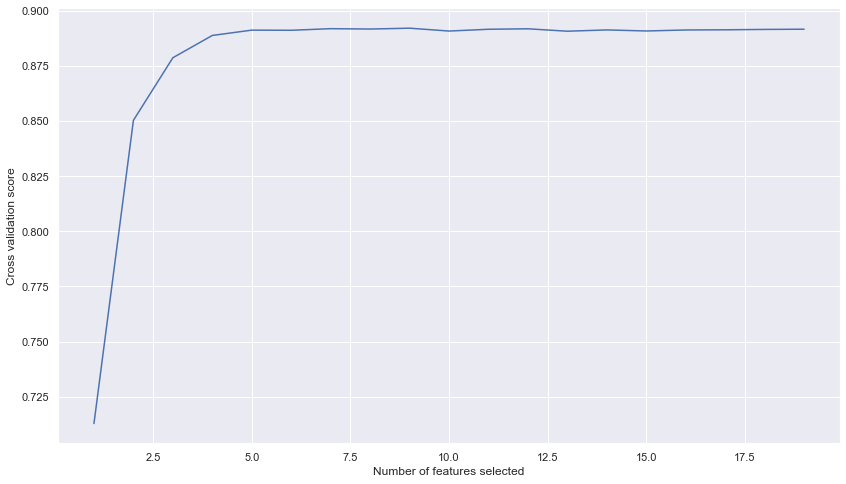

In [15]:
# Plot the result:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [16]:
# Print the featuers to be selected:
for col in X.columns[rfe.ranking_ == 1]:
    print(col)

TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
dist1
P_emaildomain
R_emaildomain
C1
C2
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D8
D9
D10
D11
D12
D13
D14
D15
M2
M3
M4
M5
M6
M8
M9
V5
V12
V13
V19
V20
V35
V36
V38
V44
V45
V47
V53
V54
V56
V61
V62
V70
V74
V75
V76
V78
V82
V83
V87
V91
V96
V97
V99
V126
V127
V128
V130
V131
V139
V143
V149
V152
V160
V165
V170
V171
V189
V203
V204
V205
V207
V209
V212
V215
V217
V222
V231
V257
V258
V264
V265
V266
V268
V271
V274
V277
V279
V280
V282
V283
V285
V287
V288
V289
V291
V292
V294
V306
V307
V308
V310
V312
V313
V314
V315
V317
V322
V323
V332
V333
id_01
id_02
id_03
id_05
id_06
id_09
id_13
id_14
id_17
id_19
id_20
id_30
id_31
id_32
id_33
id_38
DeviceType
DeviceInfo


In [17]:
useful_features = X.columns[rfe.ranking_ == 1]

In [18]:
useful_features.shape

(149,)

# Feature Engineering 

In [19]:
files = ['test_identity.csv', 
         'test_transaction.csv',
         'train_identity.csv',
         'train_transaction.csv',
        'sample_submission.csv']

In [20]:
with multiprocessing.Pool() as pool:
    test_id, test_tr, train_id, train_tr, sub = pool.map(load_data, files)

In [21]:
# useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
#                    'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
#                    'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
#                    'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
#                    'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
#                    'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
#                    'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
#                    'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
#                    'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
#                    'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
#                    'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
#                    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
#                    'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
#                    'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
#                    'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
#                    'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
#                    'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326','V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
#                    'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
#                    'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [22]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

2565

In [23]:
cols_to_drop = [col for col in train.columns if col not in useful_features]
cols_to_drop.remove('isFraud')
cols_to_drop.remove('TransactionID')
cols_to_drop.remove('TransactionDT')

In [24]:
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

282 features are going to be dropped for being useless


In [25]:
# New feature - decimal/log part of the transaction amount
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

# New feature - log part of the transaction amount
train['TransactionAmt_log'] = np.log(train['TransactionAmt'])
test['TransactionAmt_log'] = np.log(train['TransactionAmt'])

# Count encoding for card1 feature. 
# Explained in this kernel: https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

# Some arbitrary features interaction

for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))
    
for feature in ['id_34', 'id_36']:
    if feature in useful_features:
        # Count encoded for both train and test
        train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        
for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
    if feature in useful_features:
        # Count encoded separately for train and test
        train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
        test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [26]:
for col in tqdm_notebook(train.columns):
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

In [27]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,DeviceInfo__P_emaildomain,P_emaildomain__C2,card2__dist1,card1__card5,card2__id_20,card5__P_emaildomain,addr1__card1,id_01_count_dist,id_31_count_dist,id_33_count_dist
0,2987000,0,86400,68.5,4,13926,NaN,150.0,1,142.0,...,8523,4686,31072,4648,9239,508,29248,446307,450258,517251
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,...,8507,1589,18129,10936,5273,43,32205,446307,450258,517251
2,2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,...,8527,5141,23016,12999,6795,750,35560,446307,450258,517251
3,2987003,0,86499,50.0,4,18132,567.0,150.0,2,117.0,...,8544,6495,29394,9636,8638,170,47566,446307,450258,517251
4,2987004,0,86506,50.0,1,4497,514.0,150.0,2,102.0,...,4375,1589,25501,12822,7169,43,40560,19555,1061,544


In [28]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [29]:
del train
gc.collect()

123

In [30]:
X.shape, test.shape

((590540, 167), (506691, 167))

# Modelling

In [34]:
params = {'num_leaves': 349,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.0069,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.39,
          'reg_lambda': 0.648,
          'random_state': 47
         }

In [35]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(dt.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(dt.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999998	valid_1's auc: 0.906135
Early stopping, best iteration is:
[1154]	training's auc: 1	valid_1's auc: 0.906636
Fold 1 finished in 0:01:15.573327
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999768	valid_1's auc: 0.924563
Early stopping, best iteration is:
[797]	training's auc: 0.999015	valid_1's auc: 0.925053
Fold 2 finished in 0:01:44.783940
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.998174	valid_1's auc: 0.916866
Early stopping, best iteration is:
[1039]	training's auc: 0.998449	valid_1's auc: 0.916906
Fold 3 finished in 0:03:04.534194
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.995147	valid_1's auc: 0.937162
Early stopping, best iteration is:
[1244]	training's auc: 0.997599	valid_1's auc:

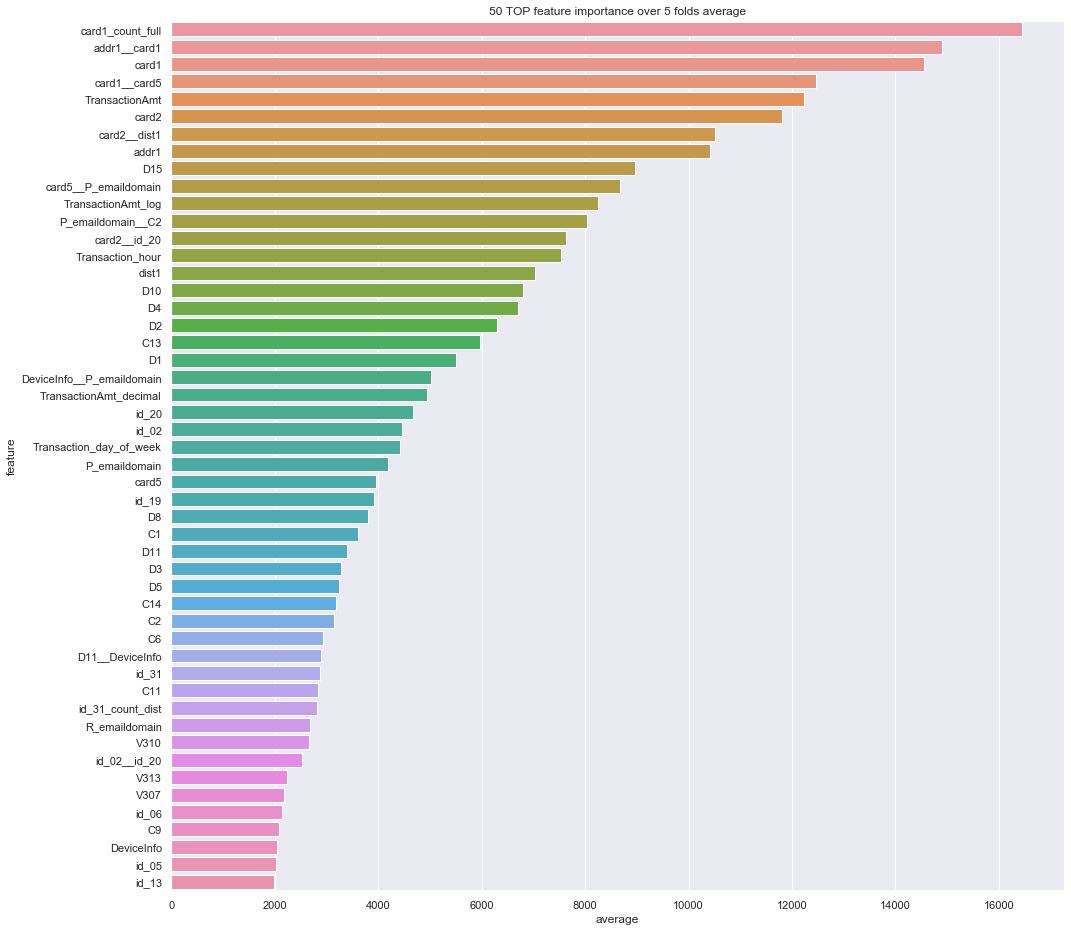

In [36]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [37]:
# clf right now is the last model, trained with 80% of data and validated with 20%
best_iter = clf.best_iteration

In [38]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

LGBMClassifier(bagging_fraction=0.418, bagging_seed=11, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.379,
               importance_type='split', learning_rate=0.0069, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.034,
               min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=1253, num_leaves=349,
               objective='binary', random_state=47, reg_alpha=0.39,
               reg_lambda=0.648, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [39]:
sub['isFraud'] = clf.predict_proba(test)[:, 1]

In [40]:
sub.head()

,TransactionID,isFraud
0,3663549,0.001446
1,3663550,0.002383
2,3663551,0.002770
3,3663552,0.002844
4,3663553,0.001579


In [41]:
sub.to_csv('Fraud_final_1.csv', index=False)

In [42]:
# Save model LGBM
from sklearn.externals import joblib
joblib.dump(clf, 'LGBM_final.sav')

['LGBM_final.sav']